In [1]:
import pandas as cd
import numpy as np

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from cuml.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import seaborn as sns
import re

In [2]:
train_data=cd.read_csv('/kaggle/input/amazon-pet-product-reviews-classification/train.csv').fillna(' ')
valid_data=cd.read_csv('/kaggle/input/amazon-pet-product-reviews-classification/valid.csv').fillna(' ')
test_data=cd.read_csv('/kaggle/input/amazon-pet-product-reviews-classification/test.csv').fillna(' ')

In [3]:
print(train_data.shape)
print(test_data.shape)
train_data.head()

(52057, 3)
(17353, 2)


,id,text,label
0,0,Sam has an everlast treat each nite before bed...,dogs
1,1,The product is as it says. I keep an eye on it...,dogs
2,2,My Kitty thinks these are treats! He loves the...,dogs
3,3,This is the third or fourth time that we've or...,dogs
4,4,Put this on both my dogs. And they are scratch...,dogs


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


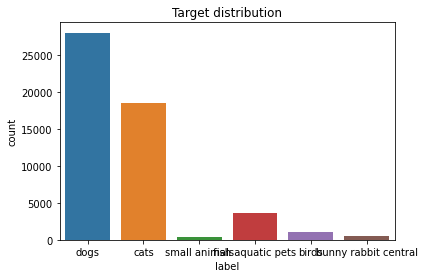

In [4]:
# sns.countplot(cd.Series.to_array(train_data['label']));
sns.countplot(train_data['label'])
plt.title('Target distribution');

In [5]:
from tqdm import tqdm
tqdm.pandas()

In [6]:
def features(df):
    df=df.copy()
    stops = stopwords.words('english')
    stemmer = PorterStemmer()
    
    # removing special characters
    df['prepared_text'] = df['text'].apply(lambda text: re.sub('[^A-Za-z]', ' ', text))
    # transform text to lowercase
    df['prepared_text'] = df['prepared_text'].str.lower()
    # tokenize the texts
    df['prepared_text'] = df['prepared_text'].apply(lambda text: word_tokenize(text))
    # removing stopwords
    df['prepared_text'] = df['prepared_text'].apply(lambda words: [word for word in words if word not in stops])
    # stemming
    df['prepared_text'] = df['prepared_text'].apply(lambda words: [stemmer.stem(word) for word in words])
    # join prepared+text to use as corpus
    df['joined_prepared_text'] = df['prepared_text'].apply(lambda words: " ".join(words))

    return df

In [7]:
train=features(train_data)
train.head()

,id,text,label,prepared_text,joined_prepared_text
0,0,Sam has an everlast treat each nite before bed...,dogs,"[sam, everlast, treat, nite, bed, like, good, ...",sam everlast treat nite bed like good tooth br...
1,1,The product is as it says. I keep an eye on it...,dogs,"[product, say, keep, eye, make, sure, doesnt, ...",product say keep eye make sure doesnt go witho...
2,2,My Kitty thinks these are treats! He loves the...,dogs,"[kitti, think, treat, love, seam, energi, get,...",kitti think treat love seam energi get sick of...
3,3,This is the third or fourth time that we've or...,dogs,"[third, fourth, time, order, big, lb, box, old...",third fourth time order big lb box old austral...
4,4,Put this on both my dogs. And they are scratch...,dogs,"[put, dog, scratch, week, later, still, flea, ...",put dog scratch week later still flea buy product


In [8]:
test=features(test_data)
test.head()

,id,text,prepared_text,joined_prepared_text
0,0,Great Filter. I have always used Marineland fi...,"[great, filter, alway, use, marineland, filter...",great filter alway use marineland filter one d...
1,1,This is a great item. My elderly dog loves it....,"[great, item, elderli, dog, love, wish, purcha...",great item elderli dog love wish purchas soone...
2,2,"I have a shep/akita mix, but I bought this mor...","[shep, akita, mix, bought, coonhound, eat, any...",shep akita mix bought coonhound eat anyth anyt...
3,3,I'm always amazed by what is available on Amaz...,"[alway, amaz, avail, amazon, toy, exactli, loo...",alway amaz avail amazon toy exactli look cat l...
4,4,I have 2 Abyssinians who will use any litterbo...,"[abyssinian, use, litterbox, past, gener, gone...",abyssinian use litterbox past gener gone somet...


In [9]:
corpus = train['joined_prepared_text'].values
corpus[:2]

array(['sam everlast treat nite bed like good tooth brush downsid find place keep stock well multipl flavor',
       'product say keep eye make sure doesnt go without reason though would quit uncomfort pup sometim need neighborhood'],
      dtype=object)

In [10]:
td = TfidfVectorizer(max_features=10000)

In [11]:
x = td.fit_transform(corpus)
x.shape

(52057, 10000)

In [12]:
labels_to_ids = {}
ids_to_labels = {}
for i, label in enumerate(sorted(train_data['label'].unique())):
    labels_to_ids[label] = i
    ids_to_labels[i] = label
    
labels_to_ids, ids_to_labels

({'birds': 0,
  'bunny rabbit central': 1,
  'cats': 2,
  'dogs': 3,
  'fish aquatic pets': 4,
  'small animals': 5},
 {0: 'birds',
  1: 'bunny rabbit central',
  2: 'cats',
  3: 'dogs',
  4: 'fish aquatic pets',
  5: 'small animals'})

In [13]:
y = train['label'].map(labels_to_ids).values
y

array([3, 3, 3, ..., 2, 3, 2])

In [14]:
clf=LogisticRegression(C=5e1, solver='qn',max_iter=400).fit(x,y)

[W] [17:52:45.811602] L-BFGS: max iterations reached
[W] [17:52:45.812090] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


Training Metrics

In [15]:
y_pred = clf.predict(x)

In [16]:
labels = list(ids_to_labels.values())

In [17]:
print(classification_report(y, y_pred, target_names=labels))

                      precision    recall  f1-score   support

               birds       0.99      0.98      0.98      1058
bunny rabbit central       0.99      0.96      0.98       570
                cats       0.91      0.88      0.90     18495
                dogs       0.92      0.94      0.93     28000
   fish aquatic pets       1.00      0.99      0.99      3592
       small animals       0.98      0.99      0.99       342

            accuracy                           0.93     52057
           macro avg       0.97      0.96      0.96     52057
        weighted avg       0.93      0.93      0.93     52057



Validation Metrics

In [19]:
val = features(valid_data)

In [20]:
val_corpus = val['joined_prepared_text'].values
val_corpus[:2]

array(['start give year old labrador retriev femal arthriti problem along weak back leg seem help littl bit would hurt tri',
       'product easi set use new puppi border colli fullgrown around crate would still lot room purchas thru amazon convieni deliveri person carri right door total cost cheaper local pet store yep love amazon'],
      dtype=object)

In [21]:
x_val = td.transform(val_corpus)
x_val.shape

(17353, 10000)

In [22]:
y_true = val['label'].map(labels_to_ids).values
y_pred = clf.predict(x_val)

In [23]:
print(classification_report(y_true, y_pred, target_names=labels))

                      precision    recall  f1-score   support

               birds       0.86      0.75      0.80       353
bunny rabbit central       0.63      0.53      0.57       190
                cats       0.79      0.77      0.78      6166
                dogs       0.84      0.87      0.86      9333
   fish aquatic pets       0.90      0.87      0.89      1197
       small animals       0.47      0.38      0.42       114

            accuracy                           0.83     17353
           macro avg       0.75      0.69      0.72     17353
        weighted avg       0.83      0.83      0.83     17353



#### Submission

In [24]:
sample_submission = cd.read_csv('/kaggle/input/amazon-pet-product-reviews-classification/sample_submission.csv')

In [25]:
test_corpus = test['joined_prepared_text'].values
test_corpus[:2]

array(['great filter alway use marineland filter one disappoint keep water clear quiet',
       'great item elderli dog love wish purchas sooner seem walk littl better sinc sleep would definit recommend product'],
      dtype=object)

In [26]:
x_test = td.transform(test_corpus)
x_test.shape

(17353, 10000)

In [27]:
y_predicted = clf.predict(x_test)

In [28]:
y_predicted.shape

(17353,)

In [30]:
sample_submission['label'] = y_predicted

In [31]:
sample_submission['label'] = sample_submission['label'].map(ids_to_labels)

In [34]:
sample_submission.to_csv('baseline_submission.csv', index=None, header=True)